In [1]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

In [59]:
df1 = pd.read_csv(r'data_files/Copy of NDVI Wheat MP 5 periods 10 Bands - Sheet1.csv')
df2 = pd.read_csv(r'data_files/Copy of NDVI Wheat MP 5 periods 10 Bands - Sheet2.csv')

In [60]:
wheat = pd.concat([df1, df2], axis=1)

In [61]:
wheat.head(2)

,0,1,2,3,4,5,6,7,8,9,Label,latitude,longitude,Dist
0,117,154,185,186,191,191,185,177,131,120,0,23.22102420000,75.54814340000,UJJAIN
1,118,153,172,182,189,181,173,157,124,118,0,22.74924340000,76.28596060000,DEWAS


In [62]:
wheat.rename({'0':'oct_2f', '1':'nov_1f', '2':'nov_2f', '3':'dec_1f', '4':'dec_2f', '5':'jan_1f', '6':'jan_2f', '7':'feb_1f', '8':'feb_2f', '9':'mar_1f', 'Label':'label', 'Dist':'district'}, axis=1, inplace=True)

In [63]:
wheat.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [64]:
wheat.head(2)

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,label,district
0,117,154,185,186,191,191,185,177,131,120,0,UJJAIN
1,118,153,172,182,189,181,173,157,124,118,0,DEWAS


In [65]:
xlsx = pd.ExcelFile('data_files/MP_crop_profiles.xlsx')
gram = pd.read_excel(xlsx, 'Gram')
mustard = pd.read_excel(xlsx, 'Mustard')
mustard1 = pd.read_excel(r'data_files/Mustard_GT_profiles_MP_30may23.xlsx')
pulses = pd.read_excel(xlsx, 'pulses')

In [66]:
mustard1.head(3)

,lat,long,Crop_Nam_1,STATE_NAME,DISTRICT,Oct_2FN,Nov_1FN,Nov_2FN,Dec_1FN,Dec_2FN,Jan_1FN,Jan_2FN,Feb_1Fn,Feb_2Fn,Mar_1Fn
0,24.031002,75.761473,2 Mustard,Madhya Pradesh,MANDSAUR,131,130,178,185,183,183,184,181,150,130
1,24.326160,75.020576,2 Mustard,Madhya Pradesh,MANDSAUR,118,130,174,190,189,187,182,160,127,125
2,25.300808,78.009660,2 Mustard,Madhya Pradesh,SHIVPURI,125,130,180,189,187,183,184,179,155,131


In [67]:
mustard1.drop(['lat', 'long', 'STATE_NAME'], axis=1, inplace=True)
mustard1.rename({'Crop_Nam_1':'label'}, axis=1, inplace=True)
mustard1.label = mustard1.label.apply(lambda row : row[2:])
mustard1.columns = ['label', 'district', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f']

In [68]:
pulses.head(2)

,label,district,Oct_2F,Nov_1F,Nov_2F,Dec_1F,Dec_2F,Jan_1F,Jan_2F,Feb_1F,Feb_2F,Mar_1F
0,Pulses,ALIRAJPUR,158,131,132,134,149,157,161,159,141,127
1,Pulses,ALIRAJPUR,156,134,134,128,143,160,158,161,157,140


In [69]:
for crop_data in [mustard, gram, pulses]:
    crop_data.columns = map(str.lower, crop_data.columns)

In [70]:
df = pd.concat([wheat, mustard, gram, pulses, mustard1], ignore_index=True)

In [71]:
df.shape[0]

19210

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19210 entries, 0 to 19209
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oct_2f    19210 non-null  object
 1   nov_1f    19210 non-null  object
 2   nov_2f    19210 non-null  object
 3   dec_1f    19210 non-null  object
 4   dec_2f    19210 non-null  object
 5   jan_1f    19210 non-null  object
 6   jan_2f    19210 non-null  object
 7   feb_1f    19210 non-null  object
 8   feb_2f    19210 non-null  object
 9   mar_1f    19210 non-null  object
 10  label     19210 non-null  object
 11  district  19210 non-null  object
dtypes: object(12)
memory usage: 1.8+ MB


In [73]:
def int_check(val):
    try:
        val = int(val)
    except:
        pass
    return val

In [74]:
df = df.drop(10906)

In [75]:
for i in df.columns[:10]:
    df[i] = df[i].astype(int)

In [76]:
df.district = df.district.astype(str)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19209 entries, 0 to 19209
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oct_2f    19209 non-null  int32 
 1   nov_1f    19209 non-null  int32 
 2   nov_2f    19209 non-null  int32 
 3   dec_1f    19209 non-null  int32 
 4   dec_2f    19209 non-null  int32 
 5   jan_1f    19209 non-null  int32 
 6   jan_2f    19209 non-null  int32 
 7   feb_1f    19209 non-null  int32 
 8   feb_2f    19209 non-null  int32 
 9   mar_1f    19209 non-null  int32 
 10  label     19209 non-null  object
 11  district  19209 non-null  object
dtypes: int32(10), object(2)
memory usage: 1.2+ MB


In [78]:
df.describe()

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f
count,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000
mean,144.435681,129.791504,130.561351,145.213650,169.505076,180.495653,183.448800,185.414858,179.702327,161.724348
std,17.304535,13.316600,14.430981,20.828144,16.231467,13.577124,6.503395,6.665503,13.541293,22.040497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130.000000,120.000000,122.000000,128.000000,158.000000,176.000000,180.000000,183.000000,176.000000,144.000000
50%,142.000000,126.000000,126.000000,138.000000,173.000000,183.000000,184.000000,187.000000,184.000000,169.000000
75%,157.000000,136.000000,133.000000,162.000000,183.000000,187.000000,188.000000,189.000000,188.000000,180.000000
max,200.000000,195.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000


In [79]:
# No null values
df.isna().sum().sum()

0

In [80]:
df.label.value_counts()

2          7175
3          5558
1          3637
Mustard    2048
Gram        351
4           245
Pulses      101
0            94
Name: label, dtype: int64

In [81]:
df['fn_label'] = df.label.apply(lambda row : 5 if (type(row) != int) else row)

In [82]:
df['label'] = df.label.apply(lambda row : 1 if (type(row) == int) else 0)

In [83]:
df.label.value_counts(), df.fn_label.value_counts()

(1    16709
 0     2500
 Name: label, dtype: int64,
 2    7175
 3    5558
 1    3637
 5    2500
 4     245
 0      94
 Name: fn_label, dtype: int64)

In [84]:
df.drop('district', axis=1, inplace=True)

## EDA

<Axes: >

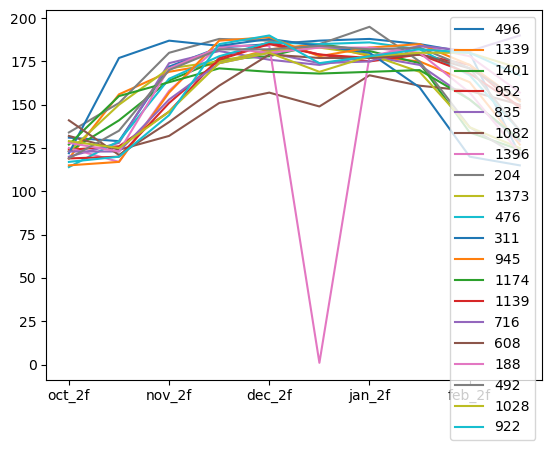

In [85]:
mustard1.iloc[:,2:].sample(20, random_state=2).T.plot()

<Axes: >

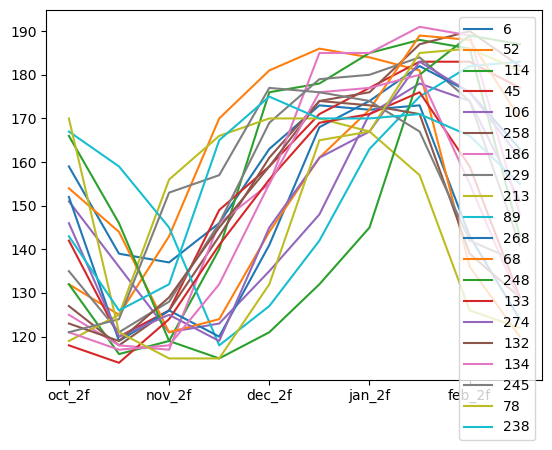

In [86]:
gram.iloc[:,2:].sample(20, random_state=0).T.plot()

<Axes: >

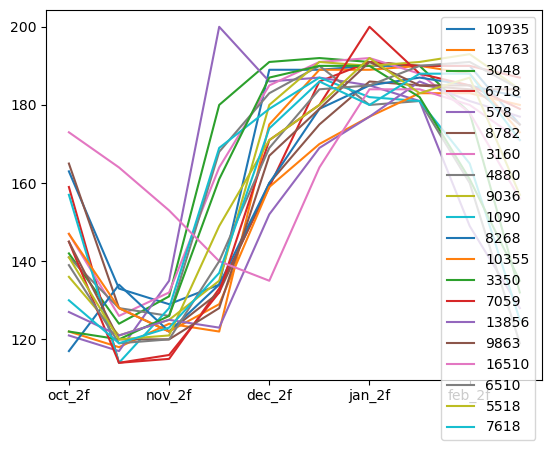

In [87]:
df[df.label == 1].iloc[:,:-2].sample(20, random_state=0).T.plot()

### Train-Val Split

In [88]:
def new_GT_initial_preprocess():
    
    all_shp_fls = np.array(glob(r'data_files\krishna\**\*.shp', recursive=True))
    pol_shp_files = [files for files in all_shp_fls if 'point' not in files]
    pol_shp_files.remove(pol_shp_files[-2])

    series = pd.Series(gp.read_file(pol_shp_files[0]).columns)
    ndvi_cols = list(series[series.apply(lambda row : True if 'FN' in row else False)])
    
    columns = ['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'label']
    
    tst_pol_wheat = pd.DataFrame(columns = columns)
    tst_pol_mustard = pd.DataFrame(columns = columns)

    for file in pol_shp_files:
        temp = gp.read_file(file)[ndvi_cols[1:11]]
        temp.columns = columns[:-1]
        # temp['district'] = 'SHIVPURI' * temp.shape[0]
        if 'Wheat' in file:
            temp['label'] = [1]*temp.shape[0]
            tst_pol_wheat = pd.concat([tst_pol_wheat, temp],ignore_index=True)
        else:
            temp['label'] = [0]*temp.shape[0]
            tst_pol_mustard = pd.concat([tst_pol_mustard, temp], ignore_index=True)
            
    tst_pol_wheat.iloc[:,:-1] = tst_pol_wheat.iloc[:,:-1].apply(lambda row:round(row*100+100))
    tst_pol_mustard.iloc[:,:-1] = tst_pol_mustard.iloc[:,:-1].apply(lambda row:round(row*100+100))
    tst_pol = pd.concat([tst_pol_wheat, tst_pol_mustard], ignore_index=True)
    
    return tst_pol

In [89]:
tst_pol = new_GT_initial_preprocess()

tst_pol.shape, tst_pol.label.value_counts()

((8323, 11),
 1    7514
 0     809
 Name: label, dtype: int64)

In [39]:
X_train = df.drop('label', axis=1)
y_train = df['label']

X_val_test = tst_pol.drop('label', axis=1)
y_val_test = tst_pol['label']

y_val_test = y_val_test.astype('int')

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, 
                                                  stratify=y_val_test, random_state=0)

X_train.drop('fn_label', axis=1, inplace=True)
# X_val.drop('fn_label', axis=1, inplace=True)

### Outlier Imputation

In [40]:
def outlier_imputation(group):
    group[(group < 100) | (group > 190)] = round(group.mean())
    return group

X_train['label'] = y_train

X_train = X_train.groupby('label').transform(outlier_imputation)

### Scaling

In [41]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# y_train = pd.get_dummies(y_train)
# y_val = pd.get_dummies(y_val)

In [42]:
pickle.dump(scaler, open(r'models/XGB_Binary_StandardScaler_1.1', 'wb'))

## Modelling-Manual

- Labels =  1 : 'Wheat, 0 : Non-Wheat
- FP = GT is non wheat but model predicted wheat
- FN = GT is wheat but model predicted non wheat

- Will be training my model on the recall score of non wheat class

In [43]:
#Imbalance observed

y_train.value_counts()

1    16709
0     2500
Name: label, dtype: int64

In [44]:
fort_nights = list(X_train.loc[:, 'oct_2f':'mar_1f'].columns)

In [50]:
params = {'n_estimators':np.arange(5,55,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,6,1)}

sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
val_scores = []
max_recall_scores = []

i = 0

while (i + 4) <= len(fort_nights):
    recall_scores = []
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        if i == 0:
            drop_cols = []
        else:
            drop_cols = fort_nights[-i:]
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train, sample_weight=sample_weights)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1])
        recall_scores.append(recall)
    recall_scores = np.array(recall_scores)
    max_scores = recall_scores.max(axis = 0)
    max_recall_scores.append([max_scores[0], max_scores[1], param_grid[np.argmax(recall_scores)]])
    i += 1
    
print('Done!!')

Done!!


In [51]:
max_recall_scores = np.array(max_recall_scores)
max_recall_scores

array([[1.0, 0.8943305829118978,
        {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 25}],
       [1.0, 0.8943305829118978,
        {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 25}],
       [1.0, 0.8456215065211605,
        {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 35}],
       [1.0, 0.7537929198828853,
        {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 5}],
       [1.0, 0.7934522225179664,
        {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 5}],
       [0.9975247524752475, 0.7492680330050572,
        {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 5}],
       [0.9975247524752475, 0.7508650519031141,
        {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 5}]],
      dtype=object)

In [54]:
test_recall_scores = []
confusion_matrices = []
test_dfs = []

for i in range(len(max_recall_scores)):
    best_classifier = XGBClassifier(**max_recall_scores[i][2])
    if i == 0:
            drop_cols = []
    else:
            drop_cols = fort_nights[-i:]
    temp_X_train = X_train.drop(drop_cols, axis=1)
    temp_X_test = X_test.drop(drop_cols, axis=1)
    best_classifier.fit(temp_X_train, y_train, sample_weight=sample_weights)
    pickle.dump(best_classifier, open(r'models/XGB_Binary_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    precision, recall, f1score, support = score(y_test, test_pred, labels=[0,1])
    test_recall_scores.append([recall[0], round(recall[1], 2)])
    confusion_matrices.append(pd.DataFrame(confusion_matrix(y_test, test_pred), 
                         columns=['Non-Wheat', 'Wheat'], 
                         index=['Non-Wheat', 'Wheat']))
    df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df1 = pd.concat([df1, temp_df], axis=1)
    test_dfs.append(df1)
    print(test_recall_scores[-1])

[1.0, 0.67]
[1.0, 0.67]
[1.0, 0.78]
[1.0, 0.51]
[1.0, 0.58]
[1.0, 0.65]
[1.0, 0.65]


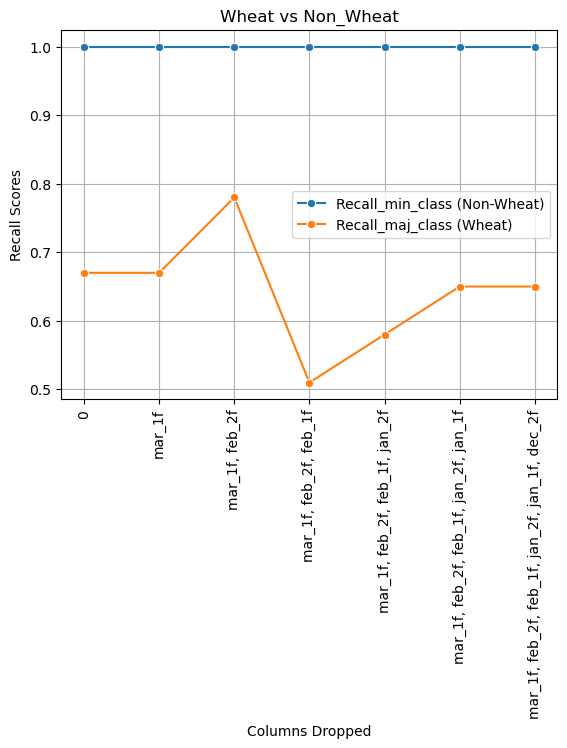

In [55]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Columns Dropped')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.grid()
plt.show()

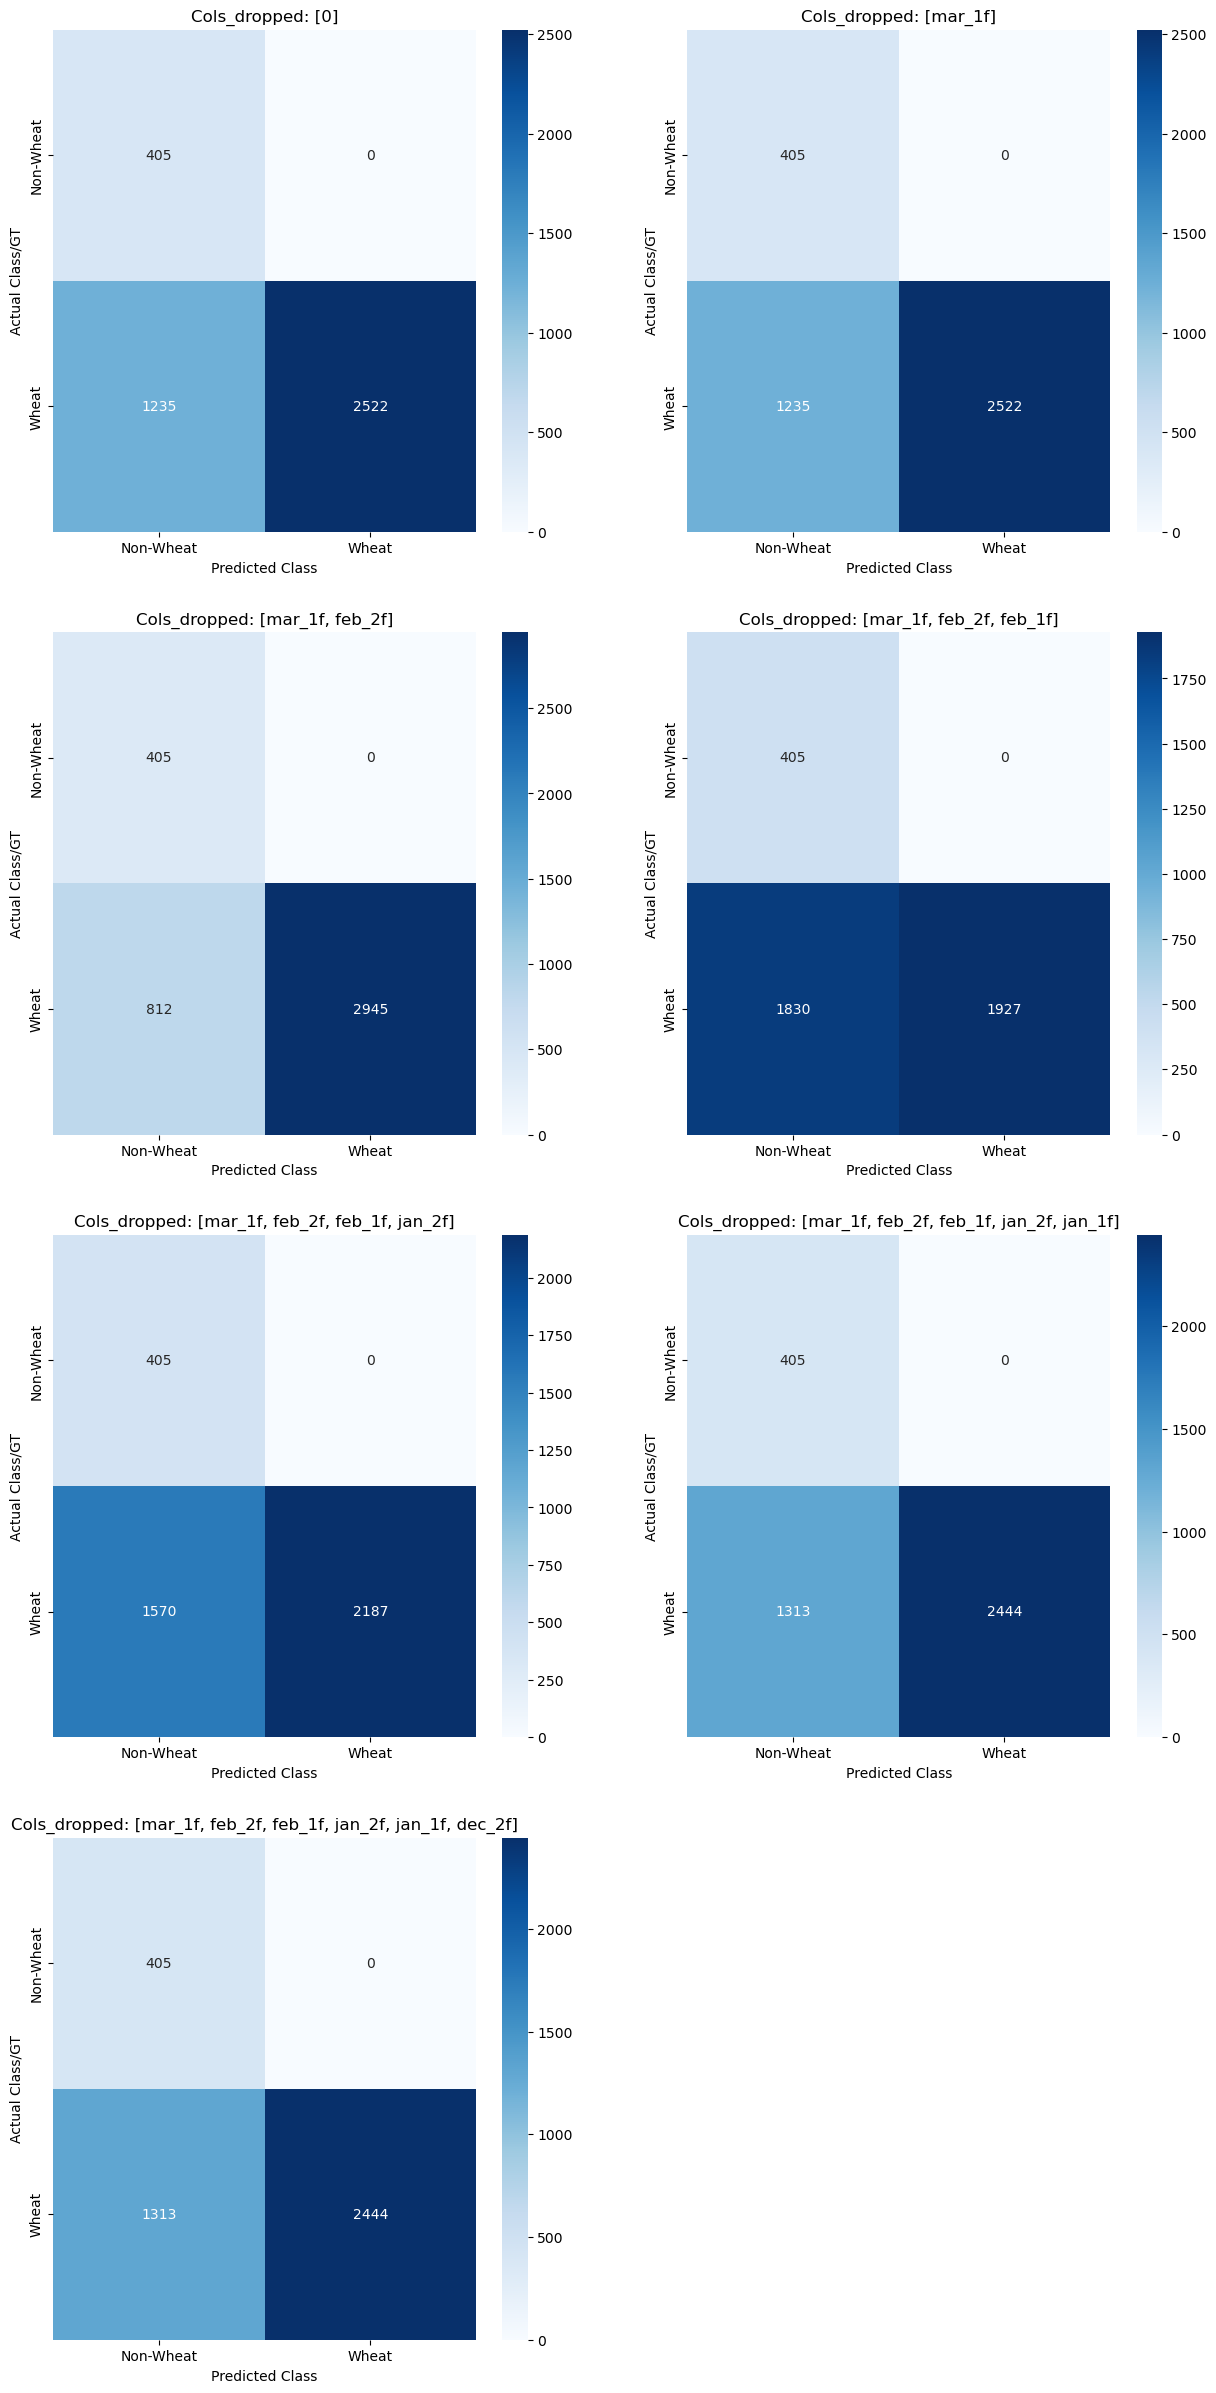

In [56]:
plt.figure(figsize=(15,30))
columns_dropped = ['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f']
for i in range(len(confusion_matrices)):
    plt.subplot(4,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Cols_dropped: [{columns_dropped[i]}]')
plt.show()